GRUPO: 
Caio Basso,
Pedro Miczewski,
Rafael Lopes,
Vitor Emmanuel

Nesta primeira etapa do trabalho realizamos os imports necessários e também o load do dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow
from glob import glob

import cv2, math

from tensorflow.keras.utils import to_categorical

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn import metrics, preprocessing
import skimage.feature as feature

import itertools    

import re 

import datetime

import time

from IPython import display

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model

## LOAD DATASET

In [ ]:
!wget https://github.com/rafz1/TDE_Simpsons/raw/main/Simpsons.zip?raw=true -O Simpsons.zip

--2022-11-16 14:11:37--  https://github.com/rafz1/TDE_Simpsons/raw/main/Simpsons.zip?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rafz1/TDE_Simpsons/main/Simpsons.zip [following]
--2022-11-16 14:11:37--  https://raw.githubusercontent.com/rafz1/TDE_Simpsons/main/Simpsons.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22300033 (21M) [application/zip]
Saving to: ‘Simpsons.zip’

Simpsons.zip        100%[===================>]  21.27M   138MB/s    in 0.2s    

2022-11-16 14:11:41 (138 MB/s) - ‘Simpsons.zip’ saved [22300033/22300033]



In [ ]:
!unzip -o Simpsons.zip -d '/content/'

Archive:  Simpsons.zip
   creating: /content/Simpsons/
   creating: /content/Simpsons/Teste/
  inflating: /content/Simpsons/Teste/bart0.jpg  
  inflating: /content/Simpsons/Teste/bart1.jpg  
  inflating: /content/Simpsons/Teste/bart10.jpg  
  inflating: /content/Simpsons/Teste/bart11.jpg  
  inflating: /content/Simpsons/Teste/bart12.jpg  
  inflating: /content/Simpsons/Teste/bart13.jpg  
  inflating: /content/Simpsons/Teste/bart14.jpg  
  inflating: /content/Simpsons/Teste/bart15.jpg  
  inflating: /content/Simpsons/Teste/bart16.jpg  
  inflating: /content/Simpsons/Teste/bart17.jpg  
  inflating: /content/Simpsons/Teste/bart18.jpg  
  inflating: /content/Simpsons/Teste/bart19.jpg  
  inflating: /content/Simpsons/Teste/bart2.jpg  
  inflating: /content/Simpsons/Teste/bart20.jpg  
  inflating: /content/Simpsons/Teste/bart21.jpg  
  inflating: /content/Simpsons/Teste/bart22.jpg  
  inflating: /content/Simpsons/Teste/bart23.jpg  
  inflating: /content/Simpsons/Teste/bart24.jpg  
  inflatin

## Criação do dataset, buscamos através do nome das imagens identificar qual a label pertencente. Na criação do dataset, foi adicionado número de referência das imagens no nome do arquivo, dessa forma foram atribuidas as labels.

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 256, 256

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [ ]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [ ]:
def load(image_file, label_file):
  input_image = tf.cast(image_file, tf.float32)
  homer_image = tf.cast(label_file, tf.float32)


  return input_image, homer_image

In [ ]:
def load_image_train(image_file, label_file):
  input_image, real_image = load(image_file, label_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
BUFFER_SIZE = 480
BATCH_SIZE = 1
input_shape_ = (256, 256, 3)
num_classes = 2

In [ ]:
def load_dataset(dirname):
    X = []
    Y = []
    for image_name in os.listdir(dirname):
        file_name = os.path.basename(image_name)
        if file_name.find("homer") != -1:
          continue
        base_file = os.path.basename(image_name).replace("bart", "homer")
        homer_file = os.path.join(dirname, base_file)

        homer = cv2.imread(homer_file)

        image = cv2.imread(dirname+'/'+image_name)

        image, homer = load_image_train(image, homer)

        X.append(image)
        Y.append(homer)

    return np.array(X), np.array(Y)

X_test, Y_test = load_dataset("/content/Simpsons/Teste/")

X_train, Y_train = load_dataset("/content/Simpsons/Treino/")

print("Training Data Shape:", X_train.shape, X_train.shape)
print("Testing Data Shape:", X_test.shape, X_test.shape)

Training Data Shape: (480, 256, 256, 3) (480, 256, 256, 3)
Testing Data Shape: (72, 256, 256, 3) (72, 256, 256, 3)


In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Define the upsampler (decoder):

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

Define the generator with the downsampler and the upsampler:

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

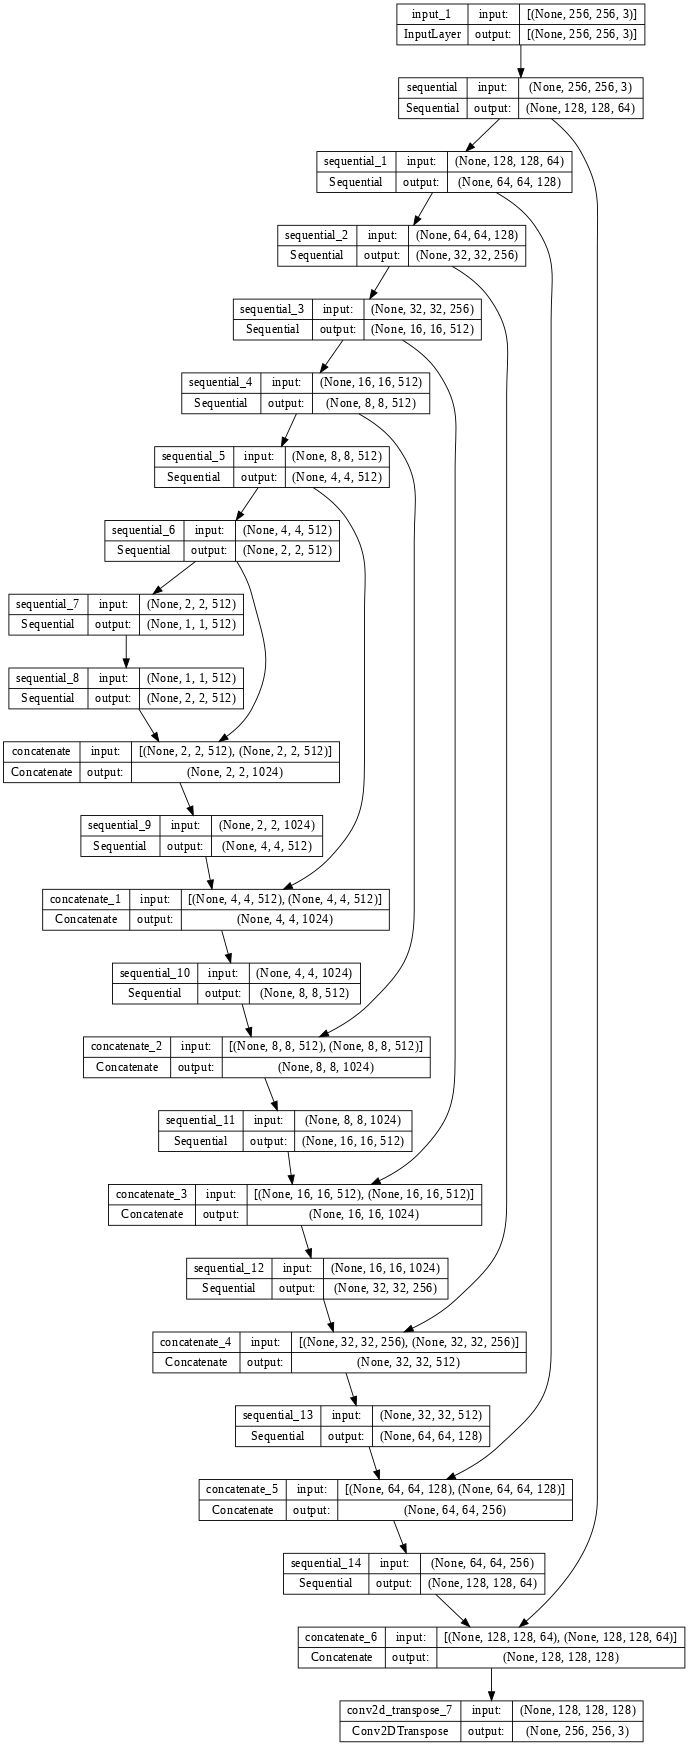

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Test the generator:

In [ ]:
teste = cv2.imread("/content/Simpsons/Treino/bart10.jpg")
teste2 = cv2.imread("/content/Simpsons/Treino/homer10.jpg")

inp, lbl = load(teste, teste2)

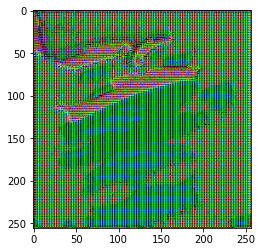

In [ ]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

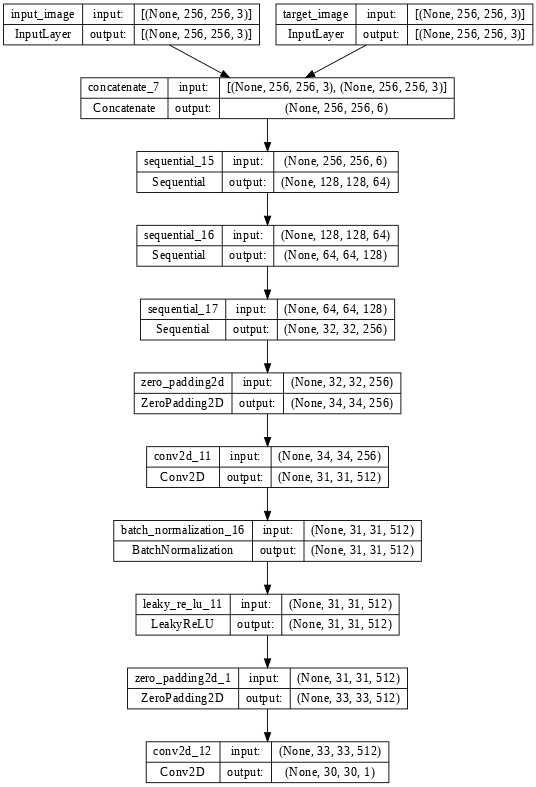

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test the discriminator:

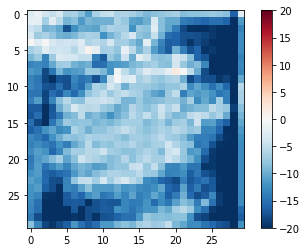

In [ ]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/checkpoints_simpsons/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Test the function:

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 88.82 sec



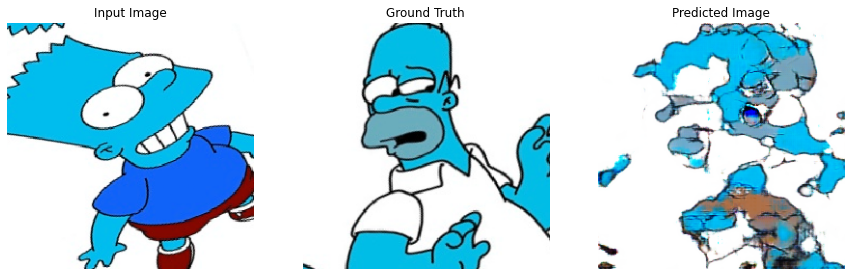

Step: 29k
....................................................................................................

In [ ]:
fit(train_dataset, test_dataset, steps=30000)

## Restore the latest checkpoint and test the network

In [ ]:
!ls {checkpoint_dir}

checkpoint		    ckpt-4.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-4.index
ckpt-1.index		    ckpt-5.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-5.index
ckpt-2.index		    ckpt-6.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-6.index
ckpt-3.index


In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(50):
  generate_images(generator, inp, tar)

# FACADES

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/checkpoints_facades/content/training_checkpoints_facades'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
import pathlib

In [ ]:
dataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]


In [ ]:
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

30168306/30168306 [==============================] - 43s 1us/step


In [ ]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [ ]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [ ]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
train_dataset_facades = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset_facades = train_dataset_facades.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_facades = train_dataset_facades.shuffle(BUFFER_SIZE)
train_dataset_facades = train_dataset_facades.batch(BATCH_SIZE)

In [ ]:
try:
  test_dataset_facades = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset_facades = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset_facades = test_dataset_facades.map(load_image_test)
test_dataset_facades = test_dataset_facades.batch(BATCH_SIZE)

In [ ]:
fit(train_dataset_facades, test_dataset_facades, steps=20000)

Time taken for 1000 steps: 87.49 sec



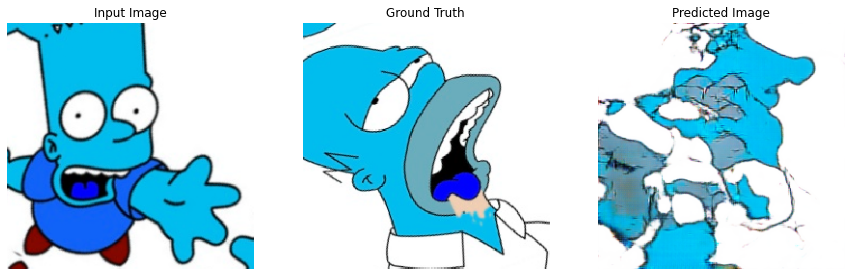

Step: 29k
....................................................................................................

In [ ]:
fit(train_dataset, test_dataset, steps=30000)

## Restore the latest checkpoint and test the network

In [ ]:
!ls {checkpoint_dir}

checkpoint		     ckpt-5.data-00000-of-00001
ckpt-10.data-00000-of-00001  ckpt-5.index
ckpt-10.index		     ckpt-6.data-00000-of-00001
ckpt-1.data-00000-of-00001   ckpt-6.index
ckpt-1.index		     ckpt-7.data-00000-of-00001
ckpt-2.data-00000-of-00001   ckpt-7.index
ckpt-2.index		     ckpt-8.data-00000-of-00001
ckpt-3.data-00000-of-00001   ckpt-8.index
ckpt-3.index		     ckpt-9.data-00000-of-00001
ckpt-4.data-00000-of-00001   ckpt-9.index
ckpt-4.index


In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(50):
  generate_images(generator, inp, tar)

Os resultados foram mais satisfatórios com transfer learning. Algumas imagens resultantes apresentam cores diferentes do input e GT, devido a dados utilizados pra treino onde existem diferentes cores, como a calça do Homer. Logo é possível melhorar os resultados fazendo pares de imagens com mais semelhanças.